# Regression - House Price(2019)

## 一、前言
- 作者：Susan Li
- 标题：Modeling Price with Regularized Linear Model & Xgboost
- 目的：**利用机器学习中的Regularized Linear Model & Xgboost 预测房价走势**
- 原文地址：https://medium.com/towards-data-science/modeling-price-with-regularized-linear-model-xgboost-55e59eae4482
- 源码地址：https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Modeling%20House%20Price%20with%20Regularized%20Linear%20Model%20%26%20Xgboost.ipynb
- 数据源： https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

**声明**
- 本文只是出于学习的目的将其翻译成中文并附上一定的注释，并没有打算将其用作盈利的目的。


我们想对房屋的价格进行建模，我们知道价格取决于房屋的位置，房屋的面积，建成年份，翻新年份，卧室数量，车库数量等。因此，这些因素促成了这种模式 - 优质的位置通常会导致更高的价格。但是，处于同一区域且面积相同的所有房屋的价格并不完全相同。这种价格差异对于我们来说是影响判断的干扰信息。我们的目标是在价格模型中寻找规律并忽略这些干扰信息。同样的概念也适用于酒店房价的建模。

## 二、数据集
首先，由于kaggle的条款原因，这里需要老铁们自己上kaggle下载相应的数据集：[数据源](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

下载后的数据名称为`train.csv`， 需要老铁们重命名为`house_train.csv`

In [2]:
df = pd.read_csv('house_train.csv')

In [3]:
df.shape

(1460, 81)

In [4]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)[:20]

PoolQC         0.995
MiscFeature    0.963
Alley          0.938
Fence          0.808
FireplaceQu    0.473
LotFrontage    0.177
GarageYrBlt    0.055
GarageCond     0.055
GarageType     0.055
GarageFinish   0.055
GarageQual     0.055
BsmtFinType2   0.026
BsmtExposure   0.026
BsmtQual       0.025
BsmtCond       0.025
BsmtFinType1   0.025
MasVnrArea     0.005
MasVnrType     0.005
Electrical     0.001
Id             0.000
dtype: float64

通过数据的读取分析，共有 81 个房屋属性特征可供我们做数据分析，但问题在于其中 19 个房屋属性特征存在数据缺失情况，而当中 4 个的缺失值超过80%， 这 4 个数据特征基本是废了。那我们直接手动将其剔除：

In [5]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id'], axis=1, inplace=True)

In [6]:
df['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

## 三、主要特征的数据分布


 mu = 180921.20 and sigma = 79415.29



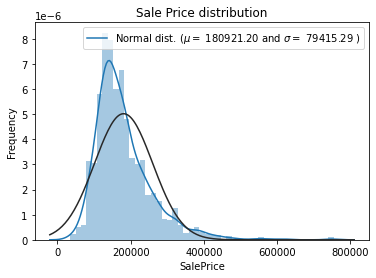

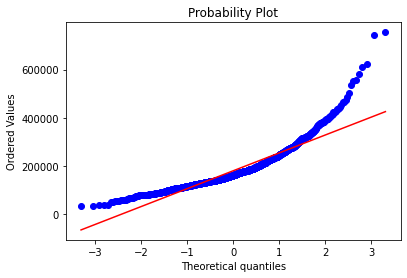

In [7]:
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show();

主要目标特征数据 SalePrice 是呈现**右偏斜的偏态分布**。线性回归模型作为我们的主要分析模型是服从正态分布的，因此，我们需要通过 log函数 将 SalePrice 进行处理使其更加偏向正态分布。


 mu = 12.02 and sigma = 0.40



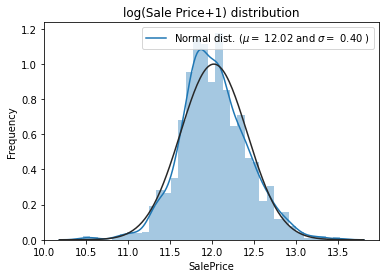

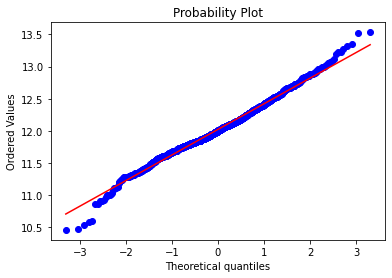

In [8]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(df['SalePrice']), plot=plt)
plt.show();

## 四、数值特征之间的相关性

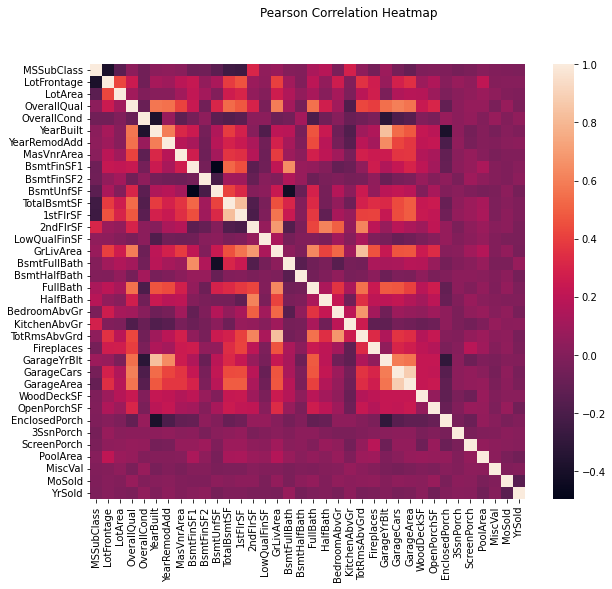

In [9]:
pd.set_option('display.precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

某些特征之间存在很强的相关性。例如，GarageYrBlt和YearBuilt，TotRmsAbvGrd和GrLivArea，GarageArea和GarageCars是强相关的。他们实际上或多或少地表达了同样的事情。稍后作者将通过 [**_ElasticNetCV_**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) 来减少这些多余信息。

## 五、SalePrice与其他数据特征之间的相关性

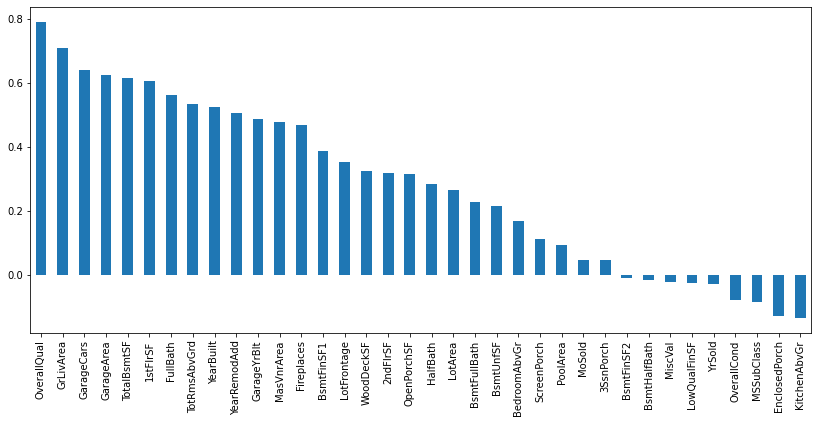

In [10]:
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

SalePrice与AlmalQual的相关性最大（约为0.8）。此外，GrLivArea的相关性超过0.7，GarageCars的相关性超过0.6。让我们更详细地看一下这 4 个数据特征。

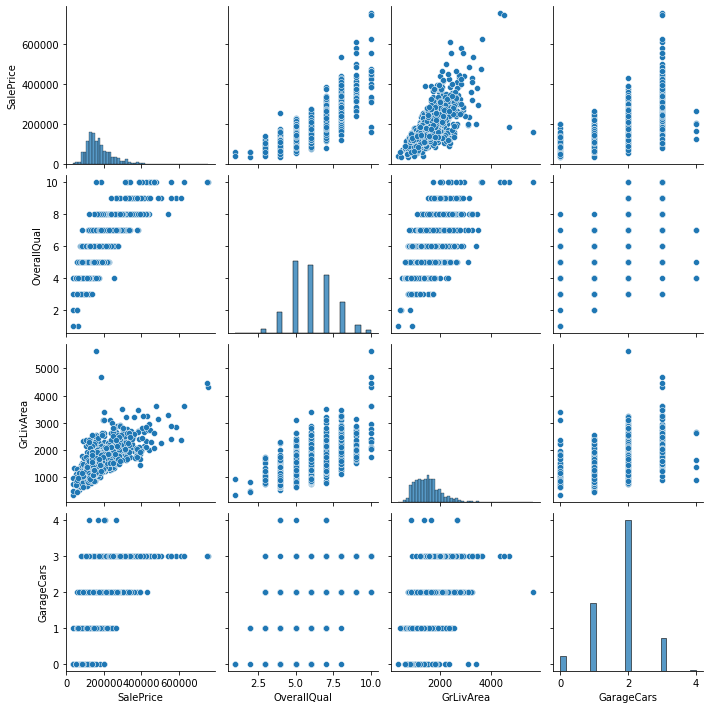

In [11]:
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();


通过对数(log)转换 目标数据特征（SalePrice) 和其他所有偏斜（skewed）的数据特征。

- 具有高度偏斜分布的对数变换特征（偏斜> 0.75）
- 虚拟编码（Dummy coding）分类特征  （详情可参考专业术语中的Dummy Variable解释）
- 用列的平均值填充 NaN。
- 训练集和测试集拆分。


In [12]:
df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])

In [13]:
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [14]:
X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 六、ElasticNetCV
-   **Ridge** 和 **Lasso** 回归是正则化线性回归模型。
-   **ElasticNe**t 本质上是**Ridge** 和 **Lasso** 的混合体，它需要最小化一个包含 **L1**（Lasso）和 **L2**（Ridge）范数的目标函数。
-   当有多个特征相互关联时，**ElasticNet** 非常有用。
-   **类 ElasticNetCV** 可用于通过交叉验证来设置参数 （α） 和 （ρ）。`alpha``l1_ratio`
-   **ElasticNetCV**：通过交叉验证获得最佳模型选择的**ElasticNet**模型。

In [15]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [16]:
cv_model.fit(X_train, y_train)

ElasticNetCV(cv=6, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_jobs=-1, normalize=True, random_state=0)

In [17]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00013634
Optimal l1_ratio: 0.700
Number of iterations 84


`0< optimal l1_ratio <1`，表示惩罚（penalty ）是L1和L2的组合，即Lasso和Ridge的组合。

In [18]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9352316018794959
Test r2 score:  0.8300355301028959
Train RMSE: 0.0963
Test RMSE: 0.1604


这里的RMSE实际上是RMSLE（ Root Mean Squared Logarithmic Error）。因为我们已经获取了实际数值的对数。

113 features, reduction of 58.91%


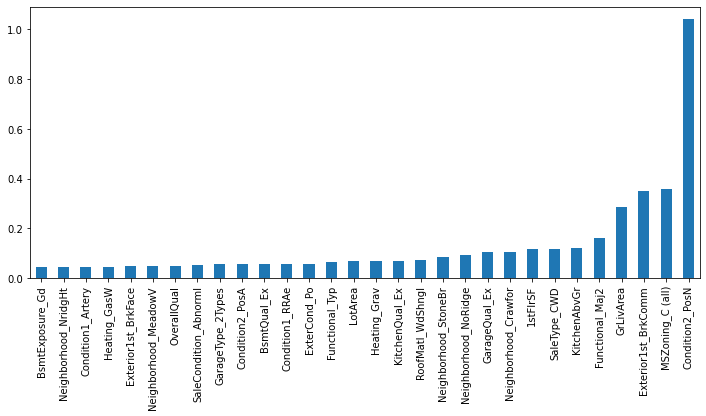

In [19]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

减少 58.91% 的数据特征看起来还是挺有效的。ElasticNetCV选择的 4 个最重要的数据特征是 **Condition2_PosN，MSZoning_C（all），Exterior1st_BrkComm和GrLivArea**。我们将看到这些数据特征与Xgboost选择的功能相比如何。

## 七、Xgboost

第一个 Xgboost 模型使用默认参数：

In [20]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [21]:
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9995312287128847
Test r2 score:  0.879442965695563
Train RMSE: 0.0087
Test RMSE: 0.1351


这结果比 ElasticNetCV 的模型好了不少！！

在第二个 Xgboost 模型中，我们逐渐添加一些参数，这些参数假设增加了模型的准确性。

In [22]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.9928421309247096
Test r2 score:  0.8793660770870737
Train RMSE: 0.0336
Test RMSE: 0.1351


比前者有所改进！！

第三个Xgboost模型，我们添加了一个学习速率（learning rate），希望它能产生一个更准确的模型。

In [23]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

Train r2 score:  0.9913698446283224
Test r2 score:  0.892895748654273
Train RMSE: 0.0367
Test RMSE: 0.1273


第三个模型就没改进了。 下面是第四个改进模型：

In [24]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

Train r2 score:  0.9867823674636849
Test r2 score:  0.8896141271373799
Train RMSE: 0.0451
Test RMSE: 0.1293


最后结论是 第二个模型（xgb_model2）未最佳！

## 第八、数据特征重要性

Xgboost选择的前 4 个最重要的数据特征是**LotArea，GrLivArea，OverallQual和TotalBsmtSF**。

ElasticNetCV和Xgboost只选择了 1 个数据特征**GrLivArea**。

因此，现在我们将选择一些相关数据特征并再次拟合Xgboost。

In [25]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 108.0),
             ('LotFrontage', 94.0),
             ('MSSubClass', 69.0),
             ('GrLivArea', 60.0),
             ('OverallQual', 56.0),
             ('BsmtUnfSF', 55.0),
             ('TotalBsmtSF', 54.0),
             ('1stFlrSF', 43.0),
             ('MoSold', 39.0),
             ('OverallCond', 37.0),
             ('BsmtFinSF1', 37.0),
             ('GarageArea', 36.0),
             ('YearBuilt', 35.0),
             ('YearRemodAdd', 33.0),
             ('OpenPorchSF', 31.0),
             ('MasVnrArea', 27.0),
             ('WoodDeckSF', 27.0),
             ('GarageYrBlt', 26.0),
             ('2ndFlrSF', 22.0),
             ('EnclosedPorch', 15.0),
             ('TotRmsAbvGrd', 14.0),
             ('YrSold', 14.0),
             ('ScreenPorch', 13.0),
             ('GarageCars', 12.0),
             ('GarageType_Attchd', 10.0),
             ('BedroomAbvGr', 9.0),
             ('Fireplaces', 9.0),
             ('SaleCondition_Abnorml', 9.0),
      

In [26]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
print(most_relevant_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'LotConfig_Corner', 'LotConfig_Inside', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Condition1_Artery', 'Condition1_Norm', 'HouseStyle_SLvl', 'RoofStyle_Gable', 'MasVnrType_BrkFace', 'ExterQual_Gd', 'ExterCond_Gd', 'BsmtExposure_Gd', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType2_BLQ', 'HeatingQC_TA', 'KitchenQual_Ex', 'Functional_Typ', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'GarageType_Attchd', 'GarageFinish_RFn', 'GarageQual_TA', 'SaleType_COD', 'SaleType_New', 'SaleCondition_Abnorml']


In [27]:
train_x=df[most_relevant_features]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [28]:
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

Train r2 score:  0.9884151099712665
Test r2 score:  0.8686860483067926
Train RMSE: 0.0426
Test RMSE: 0.1410


又一个小改进！